# Hands-on Tutorial on XAI (XAI4GNNs)
### Machine Learning and Dynamical Systems Seminar @ Alan Turing Institute

[Link](https://github.com/steveazzolin/gdl_tutorial_turinginst) to online material


The aim of this notebook is to first train a simple GIN network on a synthetic benchmark for XAI evaluation, then to show a prototypical use-case of GNNExplainer implemented by PyG along with the implementation of some common unsupervised metrics for XAI evaluation. Finally, some reference code is provided to showcase the usage of GLGExplainer. 

In [ ]:
%%capture
!pip install torch_geometric

In [ ]:
import os
import os.path as osp

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn.functional as F

import numpy as  np

from torch_geometric.datasets import BA2MotifDataset
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer
from torch_geometric.nn import GINConv, global_add_pool, MLP
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

import random
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Define and train a model

In [ ]:
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            mlp = MLP([in_channels, hidden_channels, hidden_channels])
            self.convs.append(GINConv(nn=mlp, train_eps=False))
            in_channels = hidden_channels

        self.mlp = MLP([hidden_channels, hidden_channels, out_channels],
                       norm=None, dropout=0.5)

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        x = global_add_pool(x, batch)
        return self.mlp(x)

In [ ]:
dataset = BA2MotifDataset("./data/BA2Motif")
print(dataset)

idxs = list(range(len(dataset)))
random.shuffle(idxs) # in-place operation
train_split = int(len(idxs) * 0.9)

train_loader = DataLoader(dataset[idxs[:train_split]], batch_size=64)
test_loader = DataLoader(dataset[idxs[train_split:]], batch_size=64)

Processing...


BA2MotifDataset(1000)


Done!


Label of the graph:  1


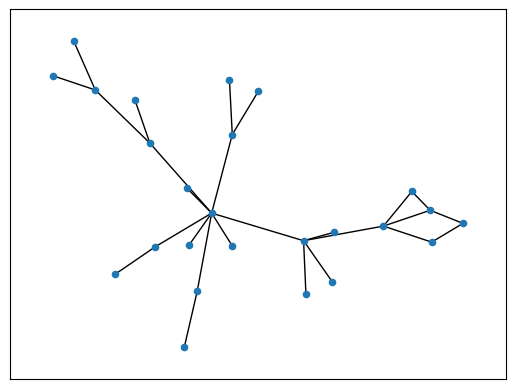

In [ ]:
i = 404
G = to_networkx(train_loader.dataset[i], to_undirected=True)
nx.draw_networkx(G, node_size=20, with_labels=False)
print("Label of the graph: ", train_loader.dataset.y[i].item())

Label of the graph:  1


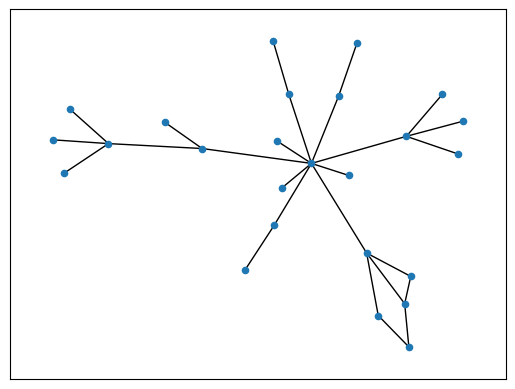

In [ ]:
i = 405
G = to_networkx(train_loader.dataset[i], to_undirected=True)
nx.draw_networkx(G, node_size=20, with_labels=False)
print("Label of the graph: ", train_loader.dataset.y[i].item())

In [ ]:
def train():
    model.train()
    total_loss = 0
    preds = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        preds.extend(out.cpu().detach().tolist())
    return total_loss / len(train_loader.dataset), preds


@torch.no_grad()
def test(loader):
    model.eval()
    total_correct = 0
    preds = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
        preds.extend(out.cpu().detach().tolist())
    return total_correct / len(loader.dataset), preds

torch.manual_seed(200)
model = GIN(dataset.num_features, 32, dataset.num_classes, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-6)
for epoch in range(50):
    loss, _ = train()
    train_acc, _ = test(train_loader)
    test_acc, _ = test(test_loader)
    if epoch % 15 == 0:
      print("Epoch=", epoch, "Loss=", loss, "Train=", round(train_acc, 2), "Test=", round(test_acc, 2))

print()
print("Train completed!")
print("Final Test acc = ", test(test_loader)[0])

Epoch= 0 Loss= 1.2549375274446275 Train= 0.5 Test= 0.53
Epoch= 15 Loss= 0.6788059923383924 Train= 0.8 Test= 0.84
Epoch= 30 Loss= 0.525704198943244 Train= 0.95 Test= 0.97
Epoch= 45 Loss= 0.27155765798356796 Train= 1.0 Test= 1.0

Train completed!
Final Test acc =  0.9


## Local Explainer

Use the [PyG](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.GNNExplainer.html#torch_geometric.explain.algorithm.GNNExplainer) implementation of [**GNNExplainer**](https://arxiv.org/abs/1903.03894).

Other implementations available:
- [DGL](https://docs.dgl.ai/generated/dgl.nn.pytorch.explain.GNNExplainer.html?highlight=gnnexplainer#dgl.nn.pytorch.explain.GNNExplainer)
- [GraphXAI](https://github.com/mims-harvard/GraphXAI/tree/main)
- [DIG](https://diveintographs.readthedocs.io/en/latest/xgraph/method.html)
- [Original implementation](https://github.com/RexYing/gnn-model-explainer)

In [ ]:
model.to("cpu")


def plot_graph(g, title):
  if len(nx.get_edge_attributes(g,"edge_mask").values()) > 0:
    colors = list(nx.get_edge_attributes(g,"edge_mask").values())
  else:
    colors = "black"

  options = {
      "node_color": "#7a7a7a",
      "edge_color": colors,
      "width": 2,
      "edge_cmap": plt.cm.Reds,
      "with_labels": False,
      "node_size":25
    }
  pos = nx.spring_layout(g, seed=10)
  nx.draw_networkx(g, pos=pos, **options)
  plt.title(title)
  plt.show()

In [ ]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200), #PGExplainer(epochs=3, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph', # 'graph' or 'node' classification
        return_type='log_probs',
    ),
)

##
# To use PGExplainer just change 'algorithm' to 'PGExplainer(epochs=10, lr=0.003)'
# Before usage, it must be trained:
##

# for epoch in tqdm(range(10)):
#     for index in range(train_split):
#       data = dataset[index]
#       loss = explainer.algorithm.train(epoch, model, data.x, data.edge_index,
#                                          target=data.y, **{"batch": data.batch})

In [ ]:
index = 2
threshold = 0.85
torch.manual_seed(200)

# Compute the explanation
e = explainer(
    dataset[index].x,
    dataset[index].edge_index,
    target=dataset[index].y,
    **{"batch": dataset[index].batch}
).get_explanation_subgraph()

# normalize in 0-1 and apply thresholding
e.edge_mask = (e.edge_mask - e.edge_mask.min()) / (e.edge_mask.max() - e.edge_mask.min())
e.edge_mask[e.edge_mask < threshold] = 0.

G_s = to_networkx(e, edge_attrs=["edge_mask"], to_undirected=True)

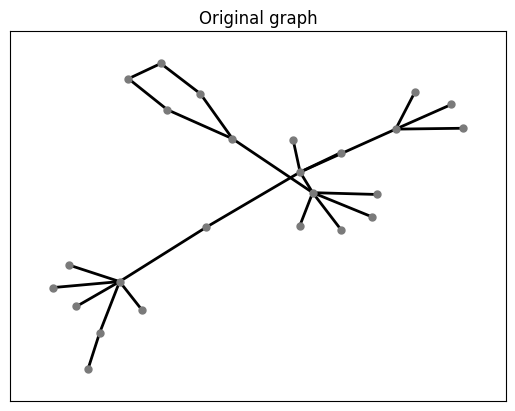

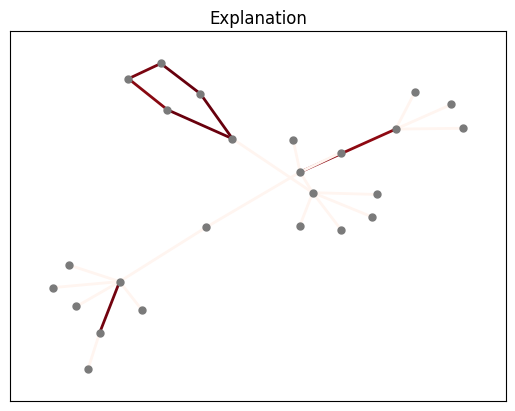

In [ ]:
G = to_networkx(dataset[index], to_undirected=True)
plot_graph(G, title="Original graph")
plot_graph(G_s, title="Explanation")

### Compute the $Fidelity_+$ and the $Fidelity_-$ metrics.

In [ ]:
def compute_fidelity(explainer, explanation):
  node_mask = explanation.get('node_mask')
  edge_mask = explanation.get('edge_mask')
  kwargs = {key: explanation[key] for key in explanation._model_args}

  y = explanation.target

  y_hat = explainer.get_prediction(
      explanation.x,
      explanation.edge_index,
      **kwargs,
  )
  y_hat_class = explainer.get_target(y_hat)
  y_hat = y_hat.softmax(-1)[:, y_hat_class]

  explain_y_hat = explainer.get_masked_prediction(
      explanation.x,
      explanation.edge_index,
      node_mask,
      edge_mask,
      **kwargs,
  )
  explain_y_hat_class = explainer.get_target(explain_y_hat)
  explain_y_hat = explain_y_hat.softmax(-1)[:, explain_y_hat_class]

  complement_y_hat = explainer.get_masked_prediction(
      explanation.x,
      explanation.edge_index,
      1. - node_mask if node_mask is not None else None,
      1. - edge_mask if edge_mask is not None else None,
      **kwargs,
  )
  complement_y_hat_class = explainer.get_target(complement_y_hat)
  complement_y_hat = complement_y_hat.softmax(-1)[:, complement_y_hat_class]

  pos_fidelity_prob = ((y_hat - complement_y_hat).float()).abs().mean()
  neg_fidelity_prob = ((y_hat - explain_y_hat).float()).abs().mean()
  return float(pos_fidelity_prob), float(neg_fidelity_prob)

setattr(e, "batch", torch.zeros(dataset[index].num_nodes, dtype=int))
fid_p, fid_m = compute_fidelity(explainer, e)

print("Fidelity+ = ", round(fid_p, 2))
print("Fidelity- = ", round(fid_m, 2))

Fidelity+ =  0.0
Fidelity- =  0.14


### Compute the $Sparsity$ metric.

In [ ]:
def sparsity(input, explanation, threshold):
  num_edges_input = input.num_edges
  num_edges_expl = sum(explanation.edge_mask >= threshold)
  return float(1- (num_edges_expl / num_edges_input).abs())

spar = sparsity(dataset[index], e, threshold)

print("Sparsity = ", round(spar, 2))

Sparsity =  0.72


## Global Explainer

In the following, an example code for [**GLGExplainer**](https://arxiv.org/abs/2210.07147) is provided.

For a complete set of examples, check out the original [repository](https://github.com/steveazzolin/gnn_logic_global_expl/tree/master)

In [ ]:
%%capture
!pip install torch-scatter ## this takes quite a while...
!pip install wandb
!pip install torch-explain

Install *networkx==2.6.3* for compatibility with the original codebase

In [ ]:
!pip install networkx==2.6.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


Note that it might be necessary to restart the environment so to make the change of version of *networkx* effective

In [ ]:
!git clone https://github.com/steveazzolin/gnn_logic_global_expl.git
!cp gnn_logic_global_expl/local_explanations/ ./local_explanations -r

Cloning into 'gnn_logic_global_expl'...
remote: Enumerating objects: 62171, done.
remote: Counting objects: 100% (11474/11474), done.
remote: Compressing objects: 100% (2927/2927), done.
remote: Total 62171 (delta 8541), reused 11452 (delta 8525), pack-reused 50697
Receiving objects: 100% (62171/62171), 113.13 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (58401/58401), done.
Updating files: 100% (13228/13228), done.


In [ ]:
import time
import sys
sys.path.insert(0, './gnn_logic_global_expl/code')

import json
import models
import utils
from local_explanations import read_bamultishapes
import networkx as nx
assert nx.__version__ == "2.6.3"

os.chdir("/content/gnn_logic_global_expl")

DATASET_NAME = "BAMultiShapes"
bamultishapes_classes_names = ["house", "grid", "wheel", "ba", "house+grid", "house+wheel", "wheel+grid", "all"]

with open("config/" + DATASET_NAME + "_params.json") as json_file:
    hyper_params = json.load(json_file)

In [ ]:
##
# Read precomputed local explanations
# In this case, they are explanations computed by
# PGExplainer for the BAMultiShapes dataset
##

adjs_train , \
edge_weights_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train = read_bamultishapes(evaluate_method=False,
                                      remove_mix=False,
                                      min_num_include=5,
                                      split="TRAIN")
adjs_val , \
edge_weights_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val = read_bamultishapes(evaluate_method=False,
                                     remove_mix=False,
                                     min_num_include=5,
                                     split="VAL")
adjs_test , \
edge_weights_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test = read_bamultishapes(evaluate_method=False,
                                      remove_mix=False,
                                      min_num_include=5,
                                      split="TEST")
transform = None
dataset_train = utils.LocalExplanationsDataset("", adjs_train, "same", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train)
dataset_val   = utils.LocalExplanationsDataset("", adjs_val, "same", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val)
dataset_test  = utils.LocalExplanationsDataset("", adjs_test, "same", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test)

train_group_loader = utils.build_dataloader(dataset_train, belonging_train, num_input_graphs=128)
val_group_loader   = utils.build_dataloader(dataset_val,   belonging_val, num_input_graphs=256)
test_group_loader  = utils.build_dataloader(dataset_test,  belonging_test, num_input_graphs=256)

In [ ]:
##
# init the models
##
torch.manual_seed(42)
len_model    = models.LEN(hyper_params["num_prototypes"],
                          hyper_params["LEN_temperature"],
                          remove_attention=hyper_params["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper_params["num_le_features"],
                                 activation=hyper_params["activation"],
                                 num_hidden=hyper_params["dim_prototypes"]).to(device)
expl         = models.GLGExplainer(len_model,
                                   le_model,
                                   device=device,
                                   hyper_params=hyper_params,
                                   classes_names=bamultishapes_classes_names,
                                   dataset_name=DATASET_NAME,
                                   num_classes=len(train_group_loader.dataset.data.task_y.unique())
                                  ).to(device)
# Train the explainer
expl.iterate(train_group_loader, val_group_loader, plot=True)

Load instead a pre-trained model for the sake of time

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([121, 162, 157, 251,  78, 102,  73,  26]))
[0.8365361  0.13674673]


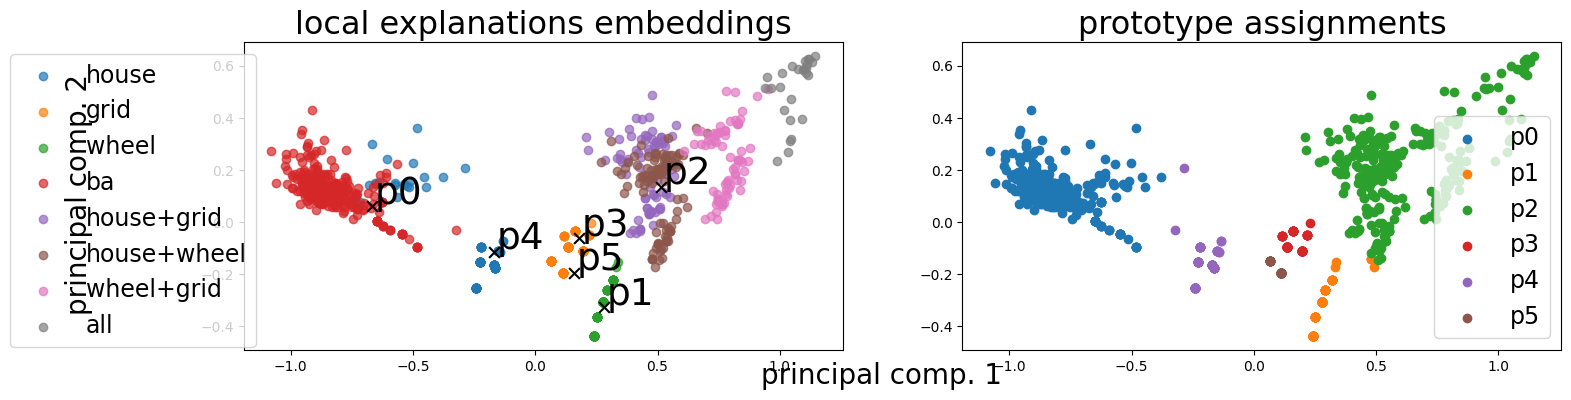

Alpha norms:
tensor([[0.4375, 0.3889, 1.0000, 0.3983, 0.2960, 0.4619],
        [0.0924, 0.1938, 1.0000, 0.1937, 0.1743, 0.1225]])
Concept Purity: 0.875196 +- 0.233278
Concept distribution:  (array([0, 1, 2, 3, 4, 5]), array([269, 161, 275, 105, 103,  57]))
Logic formulas:
For class 0:
0.9775 (feature0000000000) | (feature0000000005) | (feature0000000003) | (feature0000000001) | ((feature0000000004)
For class 1:
0.9775 (feature0000000002) | (feature0000000003 & feature0000000001) | (feature0000000004 & feature0000000003) | (feature0000000005 & feature0000000001) | (feature0000000005 & feature0000000004) | (feature0000000004 & feature0000000001) | (feature0000000001 & feature0000000002) | (feature0000000004 & feature0000000002) | (feature0000000003 & feature0000000002)
Accuracy as classifier:  0.9775
LEN fidelity:  tensor(0.9775)



In [ ]:
len_model2    = models.LEN(hyper_params["num_prototypes"],
                           hyper_params["LEN_temperature"],
                           remove_attention=hyper_params["remove_attention"]).to(device)
le_model2     = models.LEEmbedder(num_features=hyper_params["num_le_features"],
                                  activation=hyper_params["activation"],
                                  num_hidden=hyper_params["dim_prototypes"]).to(device)
best_expl     = models.GLGExplainer(len_model2,
                                    le_model2,
                                    device,
                                    hyper_params=hyper_params,
                                    classes_names=bamultishapes_classes_names,
                                    dataset_name=DATASET_NAME,
                                    num_classes=len(train_group_loader.dataset.data.task_y.unique())
                                  ).to(device)
best_expl.load_state_dict(torch.load("trained_models/BAMultiShapes.pt"))
best_expl.eval()

best_expl.inspect(train_group_loader)

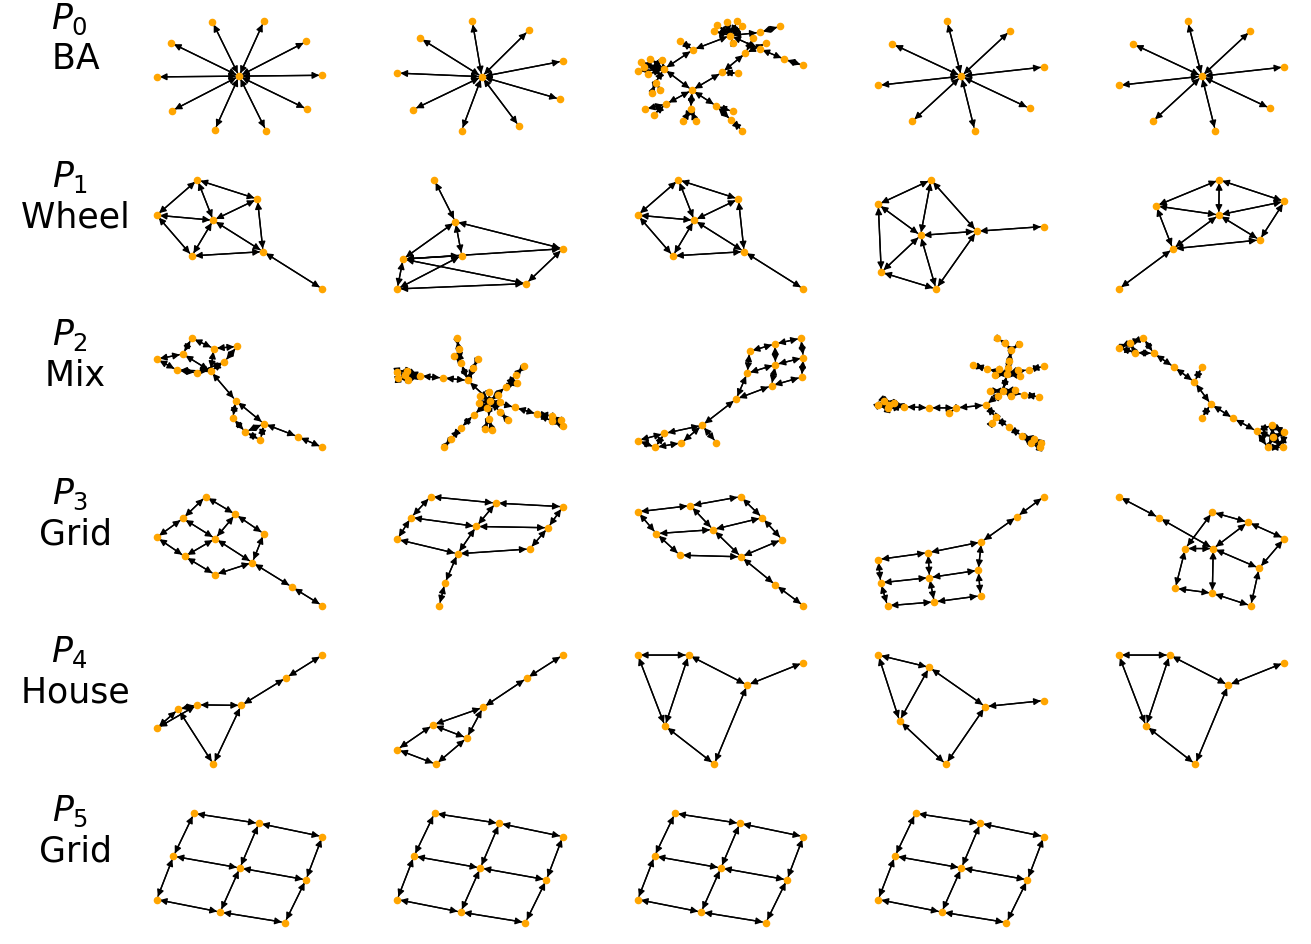

In [ ]:
best_expl.hyper["assign_func"] = "sim" # temporary change the prototype-attribution method to a soft-one for ranking local explanations based on their distance


x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = best_expl.get_concept_vector(test_group_loader,
                                                                                                                    return_raw=True)
best_expl.hyper["assign_func"] = "discrete" # reset the default prototype-attribution method

proto_names = {
    0: "BA",
    1: "Wheel",
    2: "Mix",
    3: "Grid",
    4: "House",
    5: "Grid",
}
torch.manual_seed(42)
fig = plt.figure(figsize=(15,5*2.4))
n = 0
for p in range(best_expl.hyper["num_prototypes"]):
    idxs = le_idxs[concepts_assignement.argmax(-1) == p]
    #idxs = idxs[torch.randperm(len(idxs))]    # random
    sa = concepts_assignement[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.argsort(sa[:, p], descending=True)]
    for ex in range(min(5, len(idxs))):
        n += 1
        ax = plt.subplot(best_expl.hyper["num_prototypes"],5,n)
        G = to_networkx(dataset_test[int(idxs[ex])], to_undirected=False) # set to_undirected=True to hide the arrows, but with this versioning it does not work...
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, node_size=20, ax=ax, node_color="orange")
        ax.axis("on")
        plt.box(False)

for p in range(best_expl.hyper["num_prototypes"]):
    plt.subplot(best_expl.hyper["num_prototypes"],5,5*p + 1)
    plt.ylabel(f"$P_{p}$\n {proto_names[p]}", size=25, rotation="horizontal", labelpad=50)

plt.show()